In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")
np.random.seed(42)
print("Tensorflow Version is :",tf.__version__)

Tensorflow Version is : 2.10.1


In [2]:
training_path = './dataset/train/'
#training_path = './dataset/separate_train/'

In [3]:
train_images = pd.read_csv(training_path+"/images.csv",header=None)
#train_images = pd.read_csv(training_path+"/images-1.csv",header=None)
train_labels = pd.read_csv("./dataset/train/labels.csv",header=None)
val_images = pd.read_csv("./dataset/validation/images.csv",header=None)
val_labels = pd.read_csv("./dataset/validation/labels.csv",header=None)

# Data Shaping

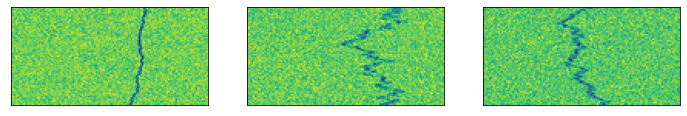

In [4]:
# according to source data 
size_image = (64,128)

# reshape the data into a shape that fits with CNN
x_train = train_images.values.reshape(len(train_images), size_image[0], size_image[1], 1)
x_val = val_images.values.reshape(len(val_images), size_image[0], size_image[1], 1)

y_train = train_labels.values
y_val = val_labels.values

# examples
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = x_train[i]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

# Image Generators for Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

# Sizes after different operations

In [47]:
def conv2d_size(input_size, kernel_size, stride):
    """ using padding='valid'
    """
    return np.floor((input_size - kernel_size + stride)/stride)

input_size = np.array([64,128])
out_first_conv = conv2d_size(input_size, 5, 1)
out_pooling1 = out_first_conv/2

out_second_conv = conv2d_size(out_pooling1, 5, 1)
out_pooling2 = out_second_conv/2

print("Size in theory")
print("First Conv Layers")
print(f"output first conv2D layer: {out_first_conv}")
print(f"output first pooling layer: {out_pooling1}")

print("Second Conv Layers")
print(f"output second conv2D layer: {out_second_conv}")
print(f"output second pooling layer: {out_pooling2}")

Size in theory
First Conv Layers
output first conv2D layer: [ 60. 124.]
output first pooling layer: [30. 62.]
Second Conv Layers
output second conv2D layer: [26. 58.]
output second pooling layer: [13. 29.]


In [29]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [48]:
conv_layer = layers.Conv2D(
    filters=32, kernel_size=5, padding="valid")

max_pool2x2 = layers.MaxPool2D(pool_size=2)

conv_layer2 = layers.Conv2D(
    filters=64, kernel_size=5, padding="valid")

# First Big Layer
hidden_output = conv_layer(x_train)
hidden_output = max_pool2x2(hidden_output)
# Second Big Layer
hidden_output = conv_layer2(hidden_output)
hidden_output = max_pool2x2(hidden_output)
print("Actual size")
hidden_output.shape

Actual size


TensorShape([9, 13, 29, 64])

# Model Section

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

## Classical Model 1

In [6]:
model = tf.keras.Sequential([
    layers.Conv2D(
        filters=32, kernel_size=5, padding="valid", input_shape=(64, 128,1)), 
    layers.BatchNormalization(), 
    layers.Activation("relu"), layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),
    
    layers.Conv2D(
        filters=64, kernel_size=5, padding="valid"), 
    layers.BatchNormalization(), 
    layers.Activation("relu"), layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024, kernel_initializer="he_normal"), 
    layers.BatchNormalization(), layers.Activation("relu"),
    layers.Dropout(0.4),

    layers.Dense(4, activation="softmax")
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


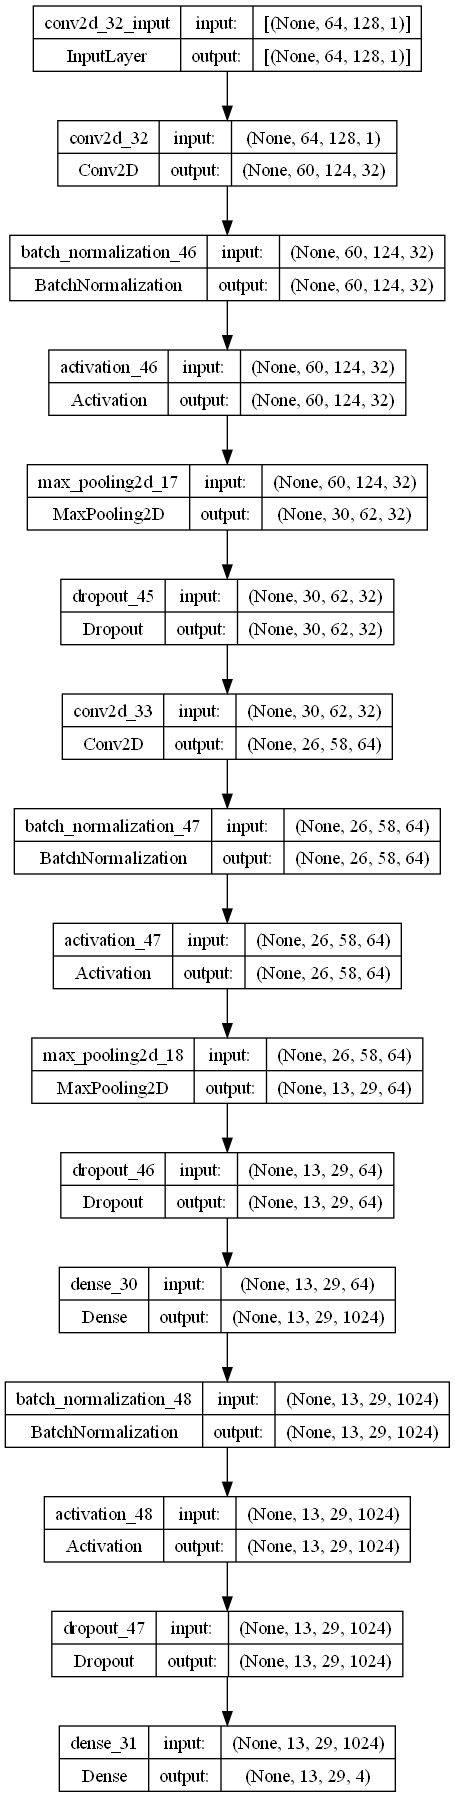

In [64]:
plot_model(model, to_file='classical_model1.png', 
    show_shapes=True, show_layer_names=True, expand_nested=True)

In [73]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 60, 124, 32)       832       
                                                                 
 batch_normalization_49 (Bat  (None, 60, 124, 32)      128       
 chNormalization)                                                
                                                                 
 activation_49 (Activation)  (None, 60, 124, 32)       0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 30, 62, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 26, 58, 64)      

In [7]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3200, 64, 128, 1)
(3200, 4)
(800, 64, 128, 1)
(800, 4)


In [ ]:
plotlosses = PlotLossesKeras()

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
# PlotLossesCallback() is not supported by Tensorflow 2.2.
callbacks = [PlotLossesKeras(), checkpoint]#, reduce_lr] 
batch_size = 2

history = model.fit(
    x=x_train,
    y=y_train,
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=[callbacks]
)


# ResidualNet

In [30]:
from functools import partial

DefaultConv2D = partial(layers.Conv2D, kernel_size=3, padding="valid",
    activation="relu", kernel_initializer="he_normal")

class ResidualUnit(layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters=filters, strides=strides, padding="same"),
            layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters=filters, padding="same"),
            layers.BatchNormalization(),
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides, padding="same"),
                layers.BatchNormalization()
            ]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z) # updates the output
        skip_Z = inputs # what we give to the skipped output
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [31]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=(64,128,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPool2D(pool_size=2, strides=2, padding="same")
])
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(4, activation="softmax"))

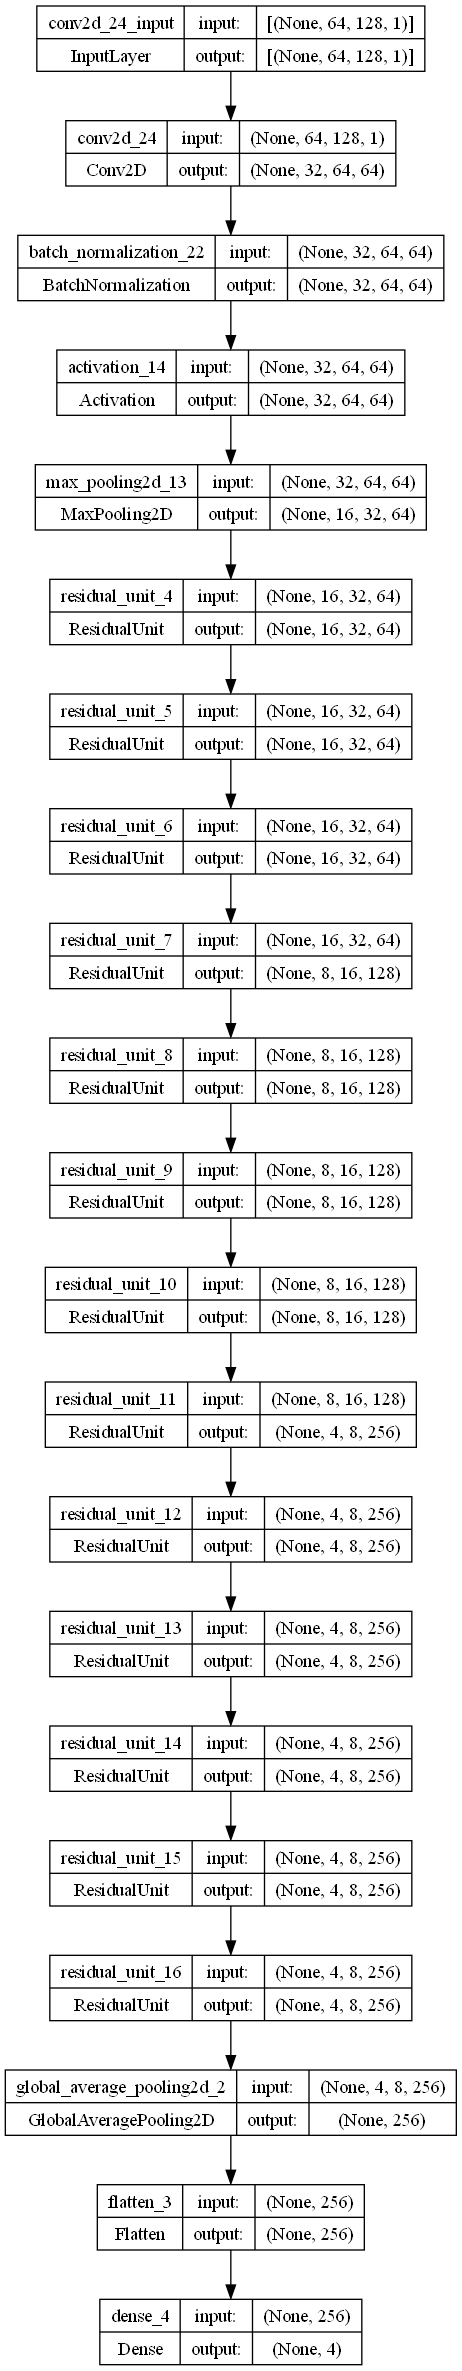

In [33]:
plot_model(model, to_file='ResNet34.png', 
    show_shapes=True, show_layer_names=True)

# SENet

In [50]:
from functools import partial
import tensorflow as tf
from tensorflow.keras import layers, Model

n_filters = 64

DefaultConv2D = partial(layers.Conv2D, kernel_size=7, padding="same",
    activation="relu", kernel_initializer="he_normal")

class SEBlock(layers.Layer):
    def __init__(self, filters, ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(filters // ratio, activation='relu')
        self.fc2 = layers.Dense(filters, activation='sigmoid')
    
    def call(self, inputs):
        squeeze = self.global_avg_pool(inputs)
        excitation = self.fc1(squeeze)
        excitation = self.fc2(excitation)
        excitation = tf.reshape(excitation, [-1, 1, 1, self.filters])
        scaled_inputs = inputs * excitation
        return scaled_inputs

class ResidualUnit(layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.filters = filters
        self.strides = strides
        self.main_layers = [
            DefaultConv2D(filters=self.filters, strides=self.strides, kernel_size=5),
            layers.BatchNormalization(),            
            self.activation,
            DefaultConv2D(filters=self.filters, kernel_size=5),
            layers.BatchNormalization(),

            self.activation,
        ]
        self.skip_layers = []
        if self.strides > 1:
            self.skip_layers = [
                DefaultConv2D(self.filters, kernel_size=1, strides=self.strides),
                layers.BatchNormalization()
            ]
        
        # SEBlock
        self.se_block = SEBlock(filters)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'strides': self.strides,
            'activation': self.activation
        })
        return config


    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        
        # Apply the SE block to the main path
        Z = self.se_block(Z)
        
        return self.activation(Z + skip_Z)

# Build the ResNet model using ResidualUnit
def build_resnet(input_shape, num_classes, num_units_per_block):
    input_tensor = layers.Input(shape=input_shape)
    x = input_tensor
    
    # Initial Conv2D layer
    x = DefaultConv2D(filters=n_filters, strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=5, strides=2, padding="same")(x)
    x = layers.Dropout(0.30)(x)
    
    # Residual blocks
    for num_units in num_units_per_block:
        x = ResidualUnit(filters=n_filters, strides=1)(x)
        for _ in range(num_units - 1):
            x = ResidualUnit(filters=n_filters)(x)
    
    # Global Average Pooling and final dense layer
    x = layers.GlobalAveragePooling2D()(x)
    output_tensor = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Building the model
input_shape = (64, 128, 1)
num_classes = 4
num_units_per_block = [1, 1, 1]  # Number of residual units in each block
model = build_resnet(input_shape, num_classes, num_units_per_block)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 64, 64)        3200      
                                                                 
 batch_normalization_17 (Bat  (None, 32, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16, 32, 64)        0         
                                                                 
 residual_unit_6 (ResidualUn  (None, 16, 32, 64)       2060

In [42]:
plot_model(model, to_file='SENet.png', 
    show_shapes=True, show_layer_names=True)

NameError: name 'plot_model' is not defined

### Training

In [43]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
# Define the number of epochs and batch size
epochs = 50
batch_size = 32

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

callbacks = [PlotLossesKeras(), early_stopping, model_checkpoint]

# Fit the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), 
                    #steps_per_epoch=steps_per_epoch,
                    #validation_steps=validation_steps, 
                    callbacks=callbacks)


Epoch 1/50
 94/100 [===========================>..] - ETA: 9s - loss: 0.7915 - accuracy: 0.6529 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

25/25 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.66      0.80       200
           1       0.00      0.00      0.00       200
           2       0.46      1.00      0.63       200
           3       1.00      1.00      1.00       200

    accuracy                           0.67       800
   macro avg       0.61      0.67      0.60       800
weighted avg       0.61      0.67      0.60       800

Classification accuracy: 0.665000


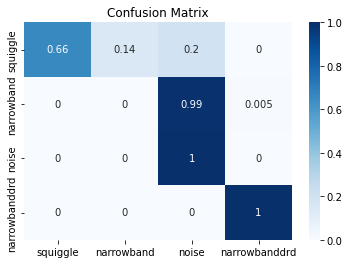

In [139]:
# Values of Recall from above confusion table can be seen on the diagonal below
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# Problems with Data?
Let's try giving it more sense's to the network

In [ ]:
FFT = tf.signal.fft2d(x_train)

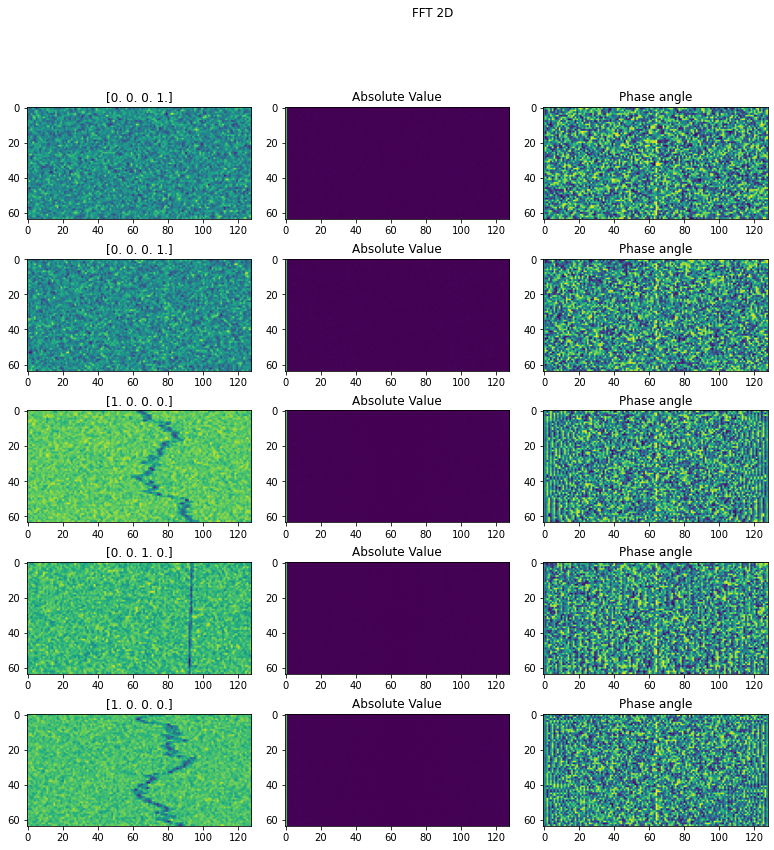

In [39]:
N = 5
fig, ax = plt.subplots(N, 3, figsize = (12, 12))
fig.suptitle('FFT 2D')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
#for x, y in [(i, j) for i in range(3) for j in range(6)]:
for i in [i for i in range(N)]:
    y = np.random.randint(low=0, high=3200)
    ax[i, 0].imshow(x_train[y])
    ax[i, 0].set_title(y_train[y])
    ax[i, 1].imshow(tf.abs(FFT[y]))
    ax[i, 1].set_title("Absolute Value")
    ax[i, 2].imshow(tf.math.angle(FFT[y]))
    ax[i, 2].set_title("Phase angle")



#     plt.imshow(x_train[0])

# plt.imshow(tf.abs(FFT[0]))

# plt.imshow(tf.math.angle(FFT[0]))

In [ ]:
model = 